/home/baha/anaconda3/envs/gym-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: Feb  1 2023 20:12:59


robotiqGymEnv __init__
argv[0]=--mp4=test.mp4
startThreads creating 1 threads.
starting thread 0
robot base reset
started thread 0 
argc=3
argv[0] = --unused
argv[1] = --mp4=test.mp4
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Graphics (RKL GT1)
GL_VERSION=4.6 (Core Profile) Mesa 22.2.5
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 22.2.5
Vendor = Intel
Renderer = Mesa Intel(R) Graphics (RKL GT1)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaround for some crash in th

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

robot base reset


xvel:  -4.061018988470956e-05
yvel:  7.544708662637271e-05
zvel:  8.342269563301637e-05


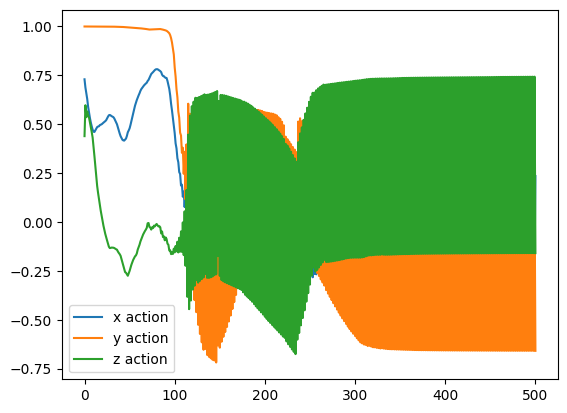

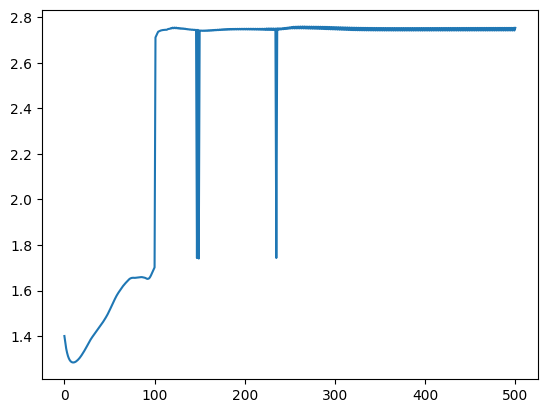

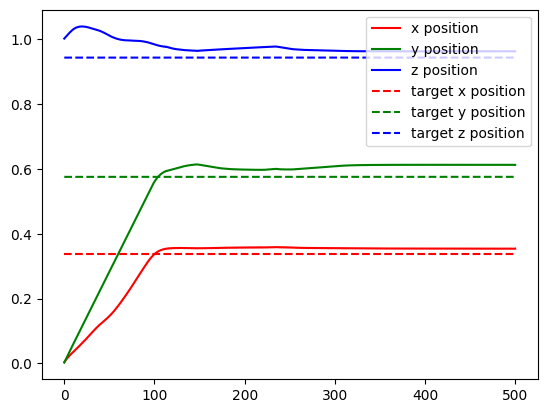

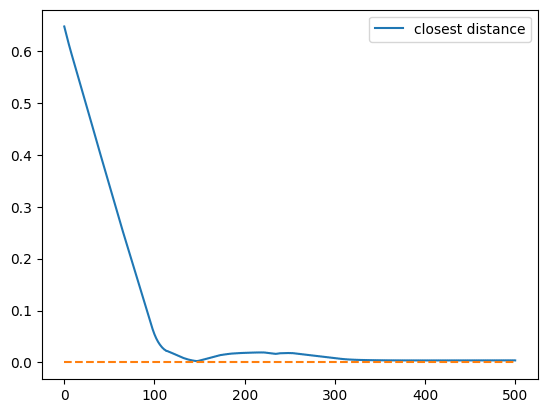

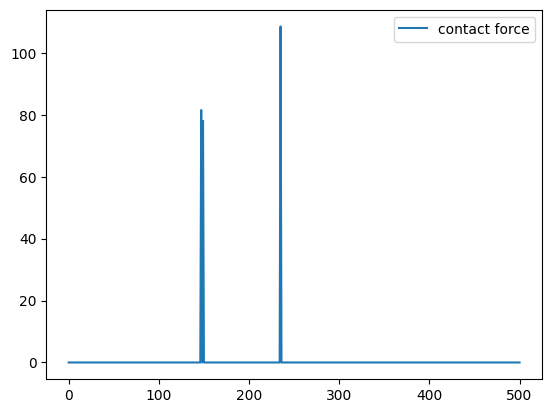

: 

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import gymnasium
sys.modules["gym"] = gymnasium
import pybullet as p
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

from stable_baselines3 import A2C, DDPG, PPO, TD3, SAC
# from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from robotiqGymEnv import robotiqGymEnv
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy


def main():

    env = robotiqGymEnv(records=True, renders=True)

    dir = "models/20230304-05:35PM_SAC_M1000_0.04_wovel/best_model.zip"
    model = SAC.load(dir)

    # mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    # print(mean_reward)

    t_ = np.array([])
    rewards_ = np.array([])
    xaction_ = np.array([])
    yaction_ = np.array([])
    zaction_ = np.array([])
    xposition_ = np.array([])
    yposition_ = np.array([])
    zposition_ = np.array([])
    targetxposition_ = np.array([])
    targetyposition_ = np.array([])
    targetzposition_ = np.array([])
    closestpoint_ = np.array([])
    contactforce_ = np.array([])


    dones = False
    obs = env.reset()

    while not dones:
        t_ = np.append(t_, env._envStepCounter)
        #   action = [0 , 0 , 0 , 0 , 0 , 0 , 0.1]
        # else:
        #   action = [0 , 0 , 0 , 1 , 0 , 1 , 1]
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones, info = env.step(action)

        rewards_ = np.append(rewards_,env._reward())
        xaction_ = np.append(xaction_,action[0])
        yaction_ = np.append(yaction_,action[1])
        zaction_ = np.append(zaction_,action[2])
        xposition_ = np.append(xposition_ , p.getBasePositionAndOrientation(env._robotiq.robotiqUid)[0][0])
        yposition_ = np.append(yposition_ , p.getBasePositionAndOrientation(env._robotiq.robotiqUid)[0][1])
        zposition_ = np.append(zposition_ , p.getBasePositionAndOrientation(env._robotiq.robotiqUid)[0][2])
        targetxposition_ = np.append(targetxposition_ , p.getBasePositionAndOrientation(env.blockUid)[0][0])
        targetyposition_ = np.append(targetyposition_ , p.getBasePositionAndOrientation(env.blockUid)[0][1] - 0.2)
        targetzposition_ = np.append(targetzposition_ , p.getBasePositionAndOrientation(env.blockUid)[0][2])
        closestpoint_ = np.append(closestpoint_ , p.getClosestPoints(env._robotiq.robotiqUid, env.blockUid, 100, -1, -1)[0][8])
        xtargetvel = p.getBaseVelocity(env.blockUid)[0][0]
        ytargetvel = p.getBaseVelocity(env.blockUid)[0][1]
        ztargetvel = p.getBaseVelocity(env.blockUid)[0][2]
        contactforce_ = np.append(contactforce_ , env._contactinfo()[4])
        env.render()
        # time.sleep(0.1)


    plt.plot(xaction_, label="x action")
    plt.plot(yaction_, label="y action")
    plt.plot(zaction_, label="z action")
    plt.legend()

    print("xvel: ", xtargetvel)
    print("yvel: ", ytargetvel)
    print("zvel: ", ztargetvel)

    plt.figure()
    plt.plot(rewards_, label="reward")

    plt.figure()
    plt.plot(xposition_, label="x position", color='r')
    plt.plot(yposition_, label="y position", color='g')
    plt.plot(zposition_, label="z position", color='b')

    plt.plot(targetxposition_, label="target x position", linestyle='--', color='r')
    plt.plot(targetyposition_, label="target y position", linestyle='--', color='g')
    plt.plot(targetzposition_, label="target z position", linestyle='--', color='b')
    plt.legend()

    plt.figure()
    plt.plot(closestpoint_, label="closest distance")
    plt.plot(np.zeros(len(closestpoint_)), linestyle='--')
    plt.legend()

    plt.figure()
    plt.plot(contactforce_, label="contact force")
    plt.legend()
  



if __name__ == "__main__":
  main()